In [111]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import myUtils
import EfficientNet
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import utils as utils
from GTSRB_utils import GTSRB_CLASSES, predict_traffic_sign, create_subset_loader
from uap_attack import generate_uap, apply_uap


In [3]:
# Direct download from original source (Institut für Neuroinformatik)
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

# Unzip both files
!unzip GTSRB_Final_Training_Images.zip
!unzip GTSRB_Final_Test_Images.zip

# Cleanup (optional)
!rm *.zip

print("Dataset downloaded and extracted!")

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Final_Test/Images/07633.ppm  
  inflating: GTSRB/Final_Test/Images/07634.ppm  
  inflating: GTSRB/Final_Test/Images/07635.ppm  
  inflating: GTSRB/Final_Test/Images/07636.ppm  
  inflating: GTSRB/Final_Test/Images/07637.ppm  
  inflating: GTSRB/Final_Test/Images/07638.ppm  
  inflating: GTSRB/Final_Test/Images/07639.ppm  
  inflating: GTSRB/Final_Test/Images/07640.ppm  
  inflating: GTSRB/Final_Test/Images/07641.ppm  
  inflating: GTSRB/Final_Test/Images/07642.ppm  
  inflating: GTSRB/Final_Test/Images/07643.ppm  
  inflating: GTSRB/Final_Test/Images/07644.ppm  
  inflating: GTSRB/Final_Test/Images/07645.ppm  
  inflating: GTSRB/Final_Test/Images/07646.ppm  
  inflating: GTSRB/Final_Test/Images/07647.ppm  
  inflating: GTSRB/Final_Test/Images/07648.ppm  
  inflating: GTSRB/Final_Test/Images/07649.ppm  
  inflating: GTSRB/Final_Test/Images/07650.ppm  
  inflating: GTSRB/Final_Test/Images/07651.ppm  
  inflating: GTSRB

In [112]:
data_dir = "GTSRB/Final_Training/Images"  # Path to training folder
test_dir = "GTSRB/Final_Test/Images"    # Path to testing folder
batch_size = 32
target_size = (240, 240)


# Define augmentation for training data
train_datagen = ImageDataGenerator(          # Normalize pixel values to [0, 1]
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,
    validation_split=0.2      # Reserve 20% for validation
)

# Generator for validation (no augmentation, same normalization)
val_datagen = ImageDataGenerator(           # Match training normalization
    validation_split=0.1
)

# Generator for testing (no augmentation, no split)
test_datagen = ImageDataGenerator(
    validation_split = 0.1
)

# Training generator (from training folder)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    subset="training",
    seed=42
)

# Validation generator (from training folder)
val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    subset="validation",
    seed=42
)

# Test generator (from test folder - no subsetting)
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    subset="validation",
    shuffle=True,  # Enable shuffling
    seed=42  # Ensure reproducibility
)

Found 31368 images belonging to 43 classes.
Found 3920 images belonging to 43 classes.
Found 3920 images belonging to 43 classes.


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("TrafficSigns_EfficientNetB1.keras")

In [9]:
train_subset_loader = create_subset_loader(train_generator, subset_fraction=0.01, batch_size=8)

uap_delta = generate_uap(model, train_subset_loader, epsilon=0.2, num_epochs=7)

Subset DataLoader: 313 samples


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


UAP Epoch [1/7] Loss: -7.4548
UAP Epoch [2/7] Loss: -7.4549
UAP Epoch [3/7] Loss: -7.4549
UAP Epoch [4/7] Loss: -7.4549
UAP Epoch [5/7] Loss: -7.4549
UAP Epoch [6/7] Loss: -7.4549
UAP Epoch [7/7] Loss: -7.4549


In [114]:
import numpy as np

np.save("uap_delta.npy", uap_delta)  # Convert to NumPy before saving


In [115]:
uap_delta = np.load("uap_delta.npy")


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
(1, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
(1, 43)


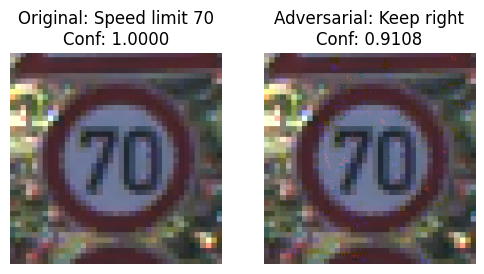

Image 1:
  Original Prediction: Speed limit 70 (Confidence: 1.0000)
  Adversarial Prediction: Keep right (Confidence: 0.9108)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
(1, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
(1, 43)


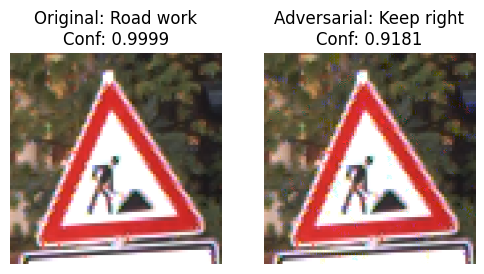

Image 2:
  Original Prediction: Road work (Confidence: 0.9999)
  Adversarial Prediction: Keep right (Confidence: 0.9181)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
(1, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
(1, 43)


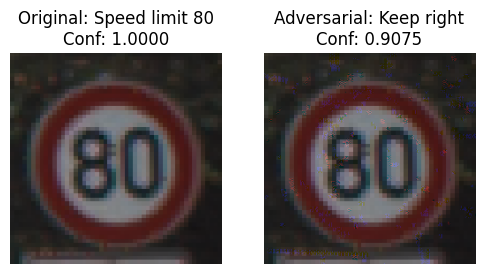

Image 3:
  Original Prediction: Speed limit 80 (Confidence: 1.0000)
  Adversarial Prediction: Keep right (Confidence: 0.9075)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
(1, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1, 43)


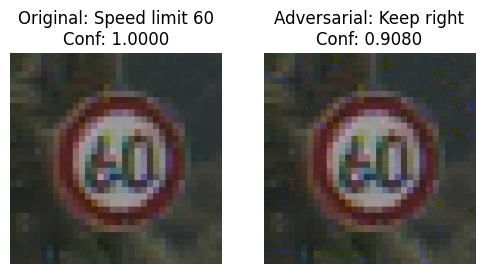

Image 4:
  Original Prediction: Speed limit 60 (Confidence: 1.0000)
  Adversarial Prediction: Keep right (Confidence: 0.9080)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
(1, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
(1, 43)


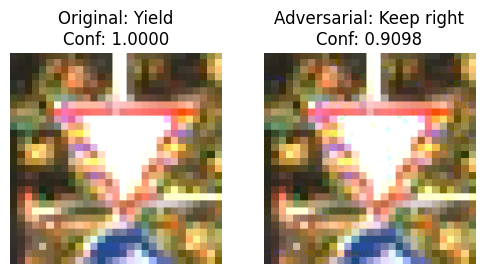

Image 5:
  Original Prediction: Yield (Confidence: 1.0000)
  Adversarial Prediction: Keep right (Confidence: 0.9098)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
(1, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
(1, 43)


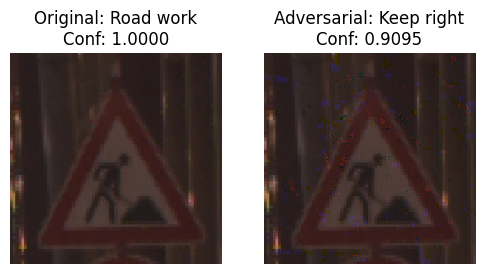

Image 6:
  Original Prediction: Road work (Confidence: 1.0000)
  Adversarial Prediction: Keep right (Confidence: 0.9095)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
(1, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
(1, 43)


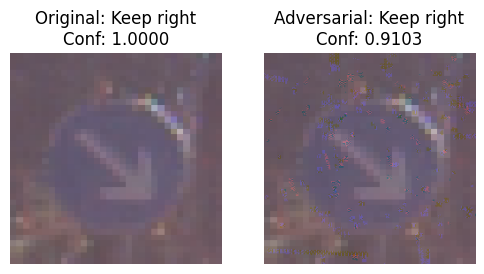

Image 7:
  Original Prediction: Keep right (Confidence: 1.0000)
  Adversarial Prediction: Keep right (Confidence: 0.9103)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
(1, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(1, 43)


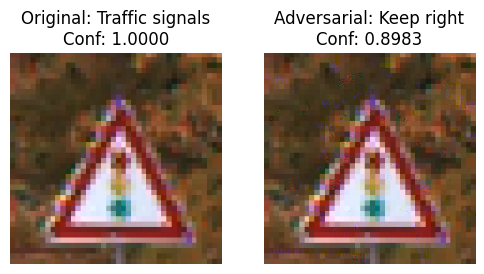

Image 8:
  Original Prediction: Traffic signals (Confidence: 1.0000)
  Adversarial Prediction: Keep right (Confidence: 0.8983)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
(1, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
(1, 43)


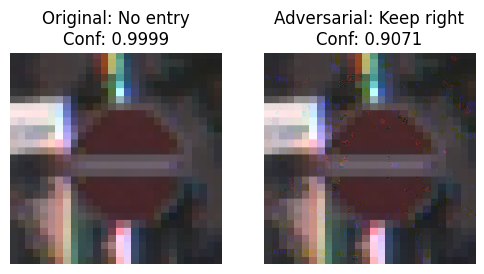

Image 9:
  Original Prediction: No entry (Confidence: 0.9999)
  Adversarial Prediction: Keep right (Confidence: 0.9071)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
(1, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
(1, 43)


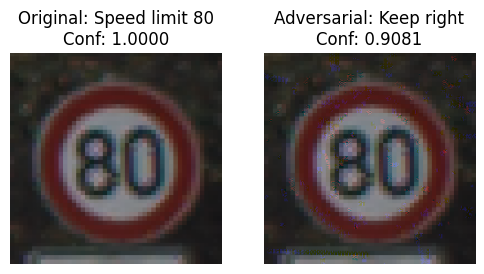

Image 10:
  Original Prediction: Speed limit 80 (Confidence: 1.0000)
  Adversarial Prediction: Keep right (Confidence: 0.9081)
--------------------------------------------------


In [116]:
subset_test_images = []
subset_test_labels = []

for _ in range(10):  # Load 10 batches
    test_images, test_labels = next(test_generator)  # Get a batch
    subset_test_images.append(test_images[0])  # Take the first image from each batch
    subset_test_labels.append(test_labels[0])  # Take the corresponding label

subset_test_images = np.array(subset_test_images)  # Convert to NumPy array
subset_test_labels = np.array(subset_test_labels)

perturbed_preds = apply_uap(model, subset_test_images, uap_delta,GTSRB_CLASSES)
